# Audio Scene Classification

This notebook guides you through building and training a simple neural network to classify audio scenes. The task is to identify the environment or setting where an audio recording was captured, such as a 'bus', 'cafe', or 'park', based solely on the sounds present in the audio data. You will implement your own classification network to perform this task.


# Import Required Libraries

In [ ]:
import torch
import torch.nn as nn
import random
from IPython.display import Audio, display
from torchsummary import summary
from torch.utils.data import DataLoader
import os
from pathlib import Path
from torch.utils.data import random_split
import importlib
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using",device)

using cuda


# Import the Audio Data


In [ ]:
# Download the dataset
zip_file_path = "/home/TCD/Lab-06/dataset.zip"
if not os.path.exists(zip_file_path):
    !curl --create-dirs -o {zip_file_path} https://tcddeeplearning.blob.core.windows.net/deeplearning202324/audiosceneclassification2025.zip
else:
    print(f"File already exists: {zip_file_path}")

# Unzip the dataset if the directory doesn't exist
dataset_dir = "/home/TCD/Lab-06/dataset/"
if not os.path.exists(dataset_dir):
    !unzip /home/TCD/Lab-06/dataset.zip -d {dataset_dir}
else:
    print(f"Dataset directory already exists: {dataset_dir}")

File already exists: /home/TCD/Lab-06/dataset.zip
Dataset directory already exists: /home/TCD/Lab-06/dataset/


# Lets Listen to the Data 👂

The lab is composed of 15 possible scenes. The cell below plays a random clip from the training data and shows its label.

Have a listen with headphones, replay the cell to load another random clip.

In [ ]:
data_root = "/home/TCD/Lab-06/dataset/small_set_complete/"
meta_filename = "meta.txt"
audio_subdir = "audio"

root = Path(data_root).resolve()
audio_dir = root / audio_subdir
meta_path = root / meta_filename

with meta_path.open() as fh:
    meta = {}
    for line in fh:
        rel_path, label, clip_id = line.strip().split("\t")
        meta[rel_path] = {"label": label, "clip_id": clip_id}

choices = list(audio_dir.glob("*.wav"))

chosen = random.choice(choices)
rel_from_audio_dir = chosen.relative_to(audio_dir)
meta_key = (Path("audio") / rel_from_audio_dir).as_posix()
info = meta.get(meta_key) or meta.get(chosen.relative_to(root).as_posix())

print(f"Playing: {chosen}")
if info:
    print(f"Label: {info['label']} | Clip: {info['clip_id']}")
else:
    print("No metadata found for this file.")

display(Audio(filename=str(chosen)))

Playing: /home/TCD/Lab-06/dataset/small_set_complete/audio/a074_80_90.wav
Label: train | Clip: a074


# Mount your drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


# Tasks
1. Implement the Dataset Class in `audio_dataset.py`
2. Implement your audio classification model in `models.py`
3. Save your model to the root of the directory as `model.pth`. [*DO NOT CHANGE THE NAME*]

We have provided instructions in each file.

Do not change the file or class names.

In [ ]:
# Run this cell to reload the LoadAudio or AudioClassifier if you have modified after the first attempt
import models, audio_dataset          # import the modules themselves
importlib.reload(models)
importlib.reload(audio_dataset)

from models import AudioClassifier    # now import the names you need
from audio_dataset import LoadAudio

In [ ]:
!pip install TorchCodec

In [ ]:
from function_test import test_dataset, print_model_summary, test_model_forward

# Immutable dataset args for evaluation
data_root = "/home/TCD/Lab-06/dataset/small_set_complete"
meta_filename = "meta.txt"
audio_subdir = "audio"

# 1) Dataset tests
ds_ok, dataset, loader = test_dataset(
    LoadAudioClass=LoadAudio,
    root_dir=data_root,
    meta_filename=meta_filename,
    audio_subdir=audio_subdir,
    torch=torch,
    DataLoader=DataLoader,
    batch_size=1
)

# 2) Model summary & param budget
num_classes = getattr(dataset, "num_classes", 15)
model = AudioClassifier(num_classes=num_classes).to(device)
ms_ok = print_model_summary(model, summary, feature_example_shape=(1, 128, 431), max_params=5_000_000)

# 3) Model forward tests
mf_ok = test_model_forward(model, loader, torch, device=device, num_classes=num_classes)

print("\n=== Overall ===")
print("ALL TESTS PASSED ✅" if (ds_ok and ms_ok and mf_ok) else "SOME TESTS FAILED ❌")


=== Dataset Tester ===
Dataset instantiation: OK
Number of samples: 600
Possible classes (15): ['beach', 'bus', 'cafe/restaurant', 'car', 'city_center', 'forest_path', 'grocery_store', 'home', 'library', 'metro_station', 'office', 'park', 'residential_area', 'train', 'tram']
Class order matches reference list: OK

Iterating 5 minibatches (feature shapes):
  Batch 1:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 2:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 3:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 4:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 5:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)

Dataset tests: PASSED ✅

=== Model Summary ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 431]              80
       BatchNorm2d-2          [-1, 8, 128, 431]         

Load dataset

In [ ]:
dataset = LoadAudio(
    root_dir=data_root,
    meta_filename="meta.txt",
    audio_subdir="audio",
    training_flag=True
)

print(f"Total samples: {len(dataset)}")
print(f"Classes: {dataset.class_names}")

Total samples: 600
Classes: ['beach', 'bus', 'cafe/restaurant', 'car', 'city_center', 'forest_path', 'grocery_store', 'home', 'library', 'metro_station', 'office', 'park', 'residential_area', 'train', 'tram']


Split dataset

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
def stratified_split(dataset, train_frac=0.8, val_frac=0.1, test_frac=0.1, seed=42):
    # X = indices of samples, Y = corresponding labels
    X = np.arange(len(dataset.samples))
    Y = np.array([dataset.label_to_idx[label] for _, label in dataset.samples])

    # First split: train vs rest
    X_train, X_rest, Y_train, Y_rest = train_test_split(
        X, Y, stratify=Y, train_size=train_frac, random_state=seed, shuffle=True
    )
    # Compute relative fraction for val/test from remaining
    rel = val_frac / (val_frac + test_frac)
    X_val, X_test, Y_val, Y_test = train_test_split(
        X_rest, Y_rest, stratify=Y_rest, train_size=rel, random_state=seed, shuffle=True
    )

    return X_train.tolist(), Y_train.tolist(), X_val.tolist(), Y_val.tolist(), X_test.tolist(), Y_test.tolist()

In [ ]:
labels = np.array([dataset.label_to_idx[label] for _, label in dataset.samples])
indices = np.arange(len(dataset))

# Train split
train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices, labels, stratify=labels, train_size=0.8, random_state=42
)

# Validation/Test split
val_frac = 0.1
test_frac = 0.1
rel = val_frac / (val_frac + test_frac)
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp, stratify=y_temp, train_size=0.5, random_state=42
)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

Train: 480, Val: 105, Test: 15


80% Train, 10% Validation, 10% Test

In [ ]:
# -------------------------
#Create dataset subsets
# -------------------------
from torch.utils.data import DataLoader, Subset
trainset = Subset(dataset, train_idx)
valset   = Subset(dataset, val_idx)
testset  = Subset(dataset, test_idx)

# Override training_flag for each subset
trainset.dataset.training_flag = True
valset.dataset.training_flag   = False
testset.dataset.training_flag  = False

In [ ]:
for i in val_idx[:10]:
    print(dataset.samples[i][0])
print("---------------------------------------")
for i in test_idx[:10]:
    print(dataset.samples[i][0])



/home/TCD/Lab-06/dataset/small_set_complete/audio/a051_10_20.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/a033_120_130.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/a119_90_100.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/a033_100_110.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/b009_160_170.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/b050_50_60.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/b057_150_160.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/b051_50_60.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/b051_90_100.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/b105_10_20.wav
---------------------------------------
/home/TCD/Lab-06/dataset/small_set_complete/audio/a003_0_10.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/b062_90_100.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/a100_90_100.wav
/home/TCD/Lab-06/dataset/small_set_complete/audio/b048_180_190.wav
/home/TCD/Lab-06/dataset/small_set_co

**Monitoring**




In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

from IPython.display import clear_output

In [ ]:
# Custom callback for plotting loss and accuracy during training

class PlotLogAccuracy:

  def __init__(self):
    self.epochs = []
    self.train_losses = []
    self.val_losses = []
    self.train_acc = []
    self.val_acc = []
    self.epoch_count = 0

  def update(self, train_loss, train_acc, val_loss, val_acc):
    self.epochs.append(self.epoch_count)
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_count += 1

    clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(self.epochs, self.train_losses, label="train loss")
    plt.plot(self.epochs, self.val_losses, label="validation loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Model Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(self.epochs, self.train_acc, label="training accuracy")
    plt.plot(self.epochs, self.val_acc, label="validation accuracy")
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Model Accuracy')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show();

plotter = PlotLogAccuracy()

# Optimiser and Dataloader Hyperparameter Setup

Here we define the dataloaders which handle the dataset, and the training optimiser.

Their hyperparameters include (but are not limited to):


*   Number of training epochs
*   Batch size
* Learning rate (step size)
* Optimiser momentum
* Dataset shuffling

In [ ]:
epochs = 65           # shorter for notebook demo - increase for training
batch_size = 64       # play with this
learning_rate = 0.005  # play with this
momentum = 0.9        # play with this

criterion = nn.CrossEntropyLoss()

# Reload ConvNN
importlib.reload(models)
from models import AudioClassifier

# setting the model (calling this again will reset the weights)
model = AudioClassifier(num_classes=dataset.num_classes).to(device)

# play with this
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         num_workers=0, pin_memory=torch.cuda.is_available())
valloader   = DataLoader(valset, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())
# testloader = DataLoader(testset, batch_size=batch_size, shuffle=False,
#                          num_workers=0, pin_memory=torch.cuda.is_available())

plotter = PlotLogAccuracy()

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

print('Setup complete.')

Setup complete.


Adding a scheduler learning rate

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
warmup = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=5)
cosine = CosineAnnealingLR(optimizer, T_max=epochs-5)
scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[5])

Start to train

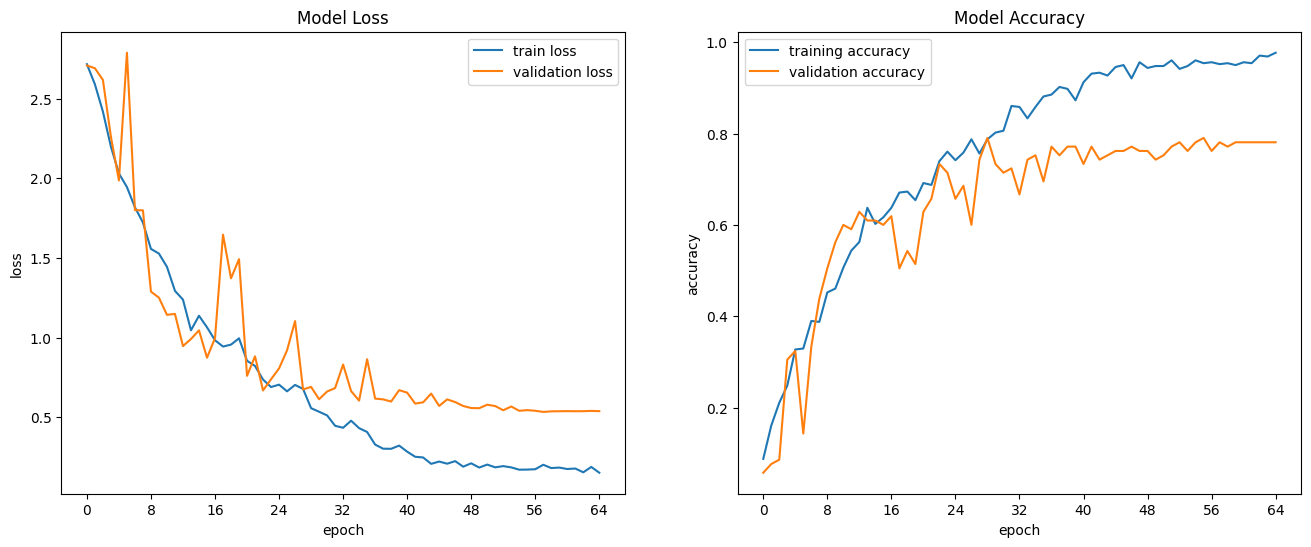

Epoch 65: Train Loss 0.1511 Acc 0.9771 | Val Loss 0.5377 Acc 0.7810
Training finished.


In [ ]:
print('Starting training...')

# Epoch Loop: It iterates through the specified number of training epochs.

for epoch in range(epochs):

    # For each epoch, all data in the dataset is processed.

    model.train() # Sets the model to training mode

    running_loss, correct, total = 0.0, 0, 0 # resetting loss/accuracy metrics

    #  Iterates through the `trainloader` to get mini-batches of data
    for x_batch, y_batch in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False):

        # copying data to the GPU (the `device`) if GPU is available
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)

        optimizer.zero_grad()           # setting up gradient to zero
        out = model(x_batch)            # Performs the forward pass
        loss = criterion(out, y_batch)  # calculates the loss
        loss.backward()                 # performs backpropagation in parallel on the batch
        optimizer.step()                # optimizer steps to update the model's weights

        # updating current training Loss and Accuracy on the mini-batch
        running_loss += loss.item() * x_batch.size(0)
        preds = out.argmax(1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_acc = correct / total

    # Computing Validation Loss and Accuracy

    model.eval() # switching model to eval mode, disabling dropout/batchnorm/other custom modules
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad(): # we disable gradient computation to save some memory
        for x_batch, y_batch in tqdm(valloader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_running_loss += loss.item() * x_batch.size(0)
            preds = out.argmax(1)
            val_total += y_batch.size(0)
            val_correct += (preds == y_batch).sum().item()
    val_loss = val_running_loss / len(valloader.dataset)
    val_acc = val_correct / val_total

    scheduler.step()

    # Record training loss and accuracy
    train_loss_hist.append(train_loss); val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc); val_acc_hist.append(val_acc)

    # At the end of the epoch, plot loss and accuracy for training/validation
    plotter.update(train_loss, train_acc, val_loss, val_acc)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}')

print('Training finished.')


Test on test set

In [ ]:
# Set model to evaluation mode
model.eval()

test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():  # no gradient computation needed
    for x_batch, y_batch in testloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)
        out = model(x_batch)
        loss = criterion(out, y_batch)
        test_loss += loss.item() * x_batch.size(0)
        preds = out.argmax(1)
        test_total += y_batch.size(0)
        test_correct += (preds == y_batch).sum().item()

final_test_loss = test_loss / len(testloader.dataset)
final_test_acc = test_correct / test_total

print(f'Test Loss: {final_test_loss:.4f}, Test Accuracy: {final_test_acc:.4f}')


NameError: name 'testloader' is not defined

In [ ]:
MODEL_PATH = 'model.pth'  # DO NOT CHANGE THE NAME, this is required by the evaluation script

# Save the entire model
torch.save(model, os.path.join('/content/gdrive/MyDrive/4c16-labs/code/lab-06', MODEL_PATH))
print('Model saved to', MODEL_PATH)

Model saved to model.pth


In [ ]:
# Run this cell to reload the LoadAudio or AudioClassifier if you have modified after the first attempt
import models, audio_dataset          # import the modules themselves
importlib.reload(models)
importlib.reload(audio_dataset)

from models import AudioClassifier    # now import the names you need
from audio_dataset import LoadAudio

# Unit Test of Dataset and Model
In the cell below, we check your dataset and model inputs, outputs and variables are as we expect them.

If you fail any of these tests, your model or dataset will be rejected by the testing server.

# Train your model
Call your dataset, optimizers, scheduelers, implement training and validation dataloaders. Write your training loop.



## Data Preprocessing and Feature Engineering
*   **Spectrograms:** Convert audio signals into spectrograms (time-frequency representations). These can be treated as images and processed using Convolutional Neural Networks (CNNs) designed for 2D data.

*   **Mel-Scale Frequency Cepstral Coefficients (MFCCs):** Instead of using raw audio waveforms, consider extracting more informative features like MFCCs. The human ear perceives frequencies on a non-linear scale (mel scale). MFCCs capture the spectral envelope of the sound, which is more relevant for human perception and often leads to better performance in audio tasks.
